In [1]:
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from IPython.display import display
from ipyfilechooser import FileChooser
%matplotlib widget
from scipy.stats import zscore
from sklearn.datasets import make_swiss_roll
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import Isomap
import networkx as nx
from scipy.stats import entropy
import warnings
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
warnings.filterwarnings("ignore")

In [2]:
try: # tries to retrieve dpath either from a previous run or from a previous notebook
    %store -r dpath
except:
    print("the path was not defined in store")
    #dpath = "/Users/mb/Documents/Syntuitio/AudreyHay/PlanB/ExampleRedLines/2022_08_06/13_30_01/My_V4_Miniscope/"
    dpath = "//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/"

fc1 = FileChooser(dpath,select_default=True, show_only_dirs = True, title = "<b>Folder with videos</b>")
display(fc1)

# Sample callback function
def update_my_folder(chooser):
    global dpath
    dpath = chooser.selected
    %store dpath
    return 

# Register callback function
fc1.register_callback(update_my_folder)

FileChooser(path='\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\Analysed2025_AB\_baseline_analysis\VigSt_…

In [3]:
combined_df = pd.read_excel(f'{dpath}/VigStates_Global.xlsx', index_col=0)
desired_order = ['AW','QW', 'NREM', 'IS', 'REM', 'undefined']   
NrSubtype='L1NDNF_mice' #['L1NDNF_mice','L2_3_mice']

In [4]:
combined_df['Unique_Unit'] = combined_df['Unique_Unit'].astype(int).astype(str)
combined_df['UnitNumber'] = combined_df['UnitNumber'].astype(str)
combined_df['UnitValue'] = combined_df['UnitValue'].astype(str)
combined_df['Unit_ID'] = combined_df['Mice'] + combined_df['Unique_Unit']
combined_df['Substate_ID'] = combined_df['Mice'] + combined_df['Session'] + combined_df['Substate'] + combined_df['SubstateNumber'].astype(str)
combined_df['Session_ID'] = combined_df['Session_Date'] + '_' + combined_df['Session_Time'].astype(str)
combined_df['NormalizedAUC_calcium'] = combined_df['AUC_calcium'] / combined_df['DurationSubstate']

combined_df_Drug=combined_df.copy()
combined_df_Drug = combined_df_Drug[combined_df_Drug['Drug'] == 'baseline']
combined_df_Drug = combined_df_Drug[combined_df_Drug['NeuronType'] == NrSubtype]

DataType='NormalizedAUC_calcium' # NormalizedAUC_calcium, SpikeActivityHz , DeconvSpikeMeanActivity, CalciumActivity

data_origin = combined_df_Drug.pivot_table(index='Unit_ID', columns='Substate', values=DataType, aggfunc='mean')   
try : data_origin = data_origin[desired_order]
except: pass

In [5]:
del data_origin['undefined']
del data_origin['IS']
data_origin=data_origin.dropna(axis=0)
vigst_nb=np.shape(data_origin)[1]
print(np.shape(data_origin))
data=data_origin.div(data_origin.sum(axis=1), axis=0)

(228, 4)


### HDBSCAN Clustering

In [6]:
n_neighbors=90 #8
min_dist=.9 #.9

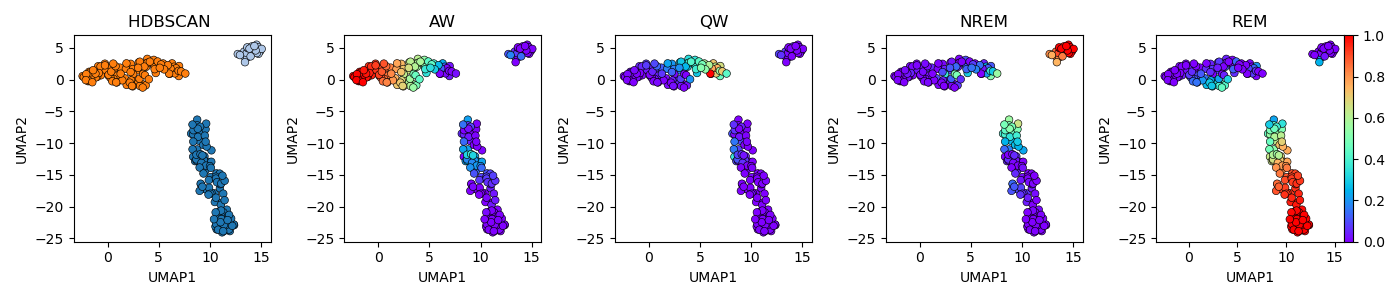

Entropy of distribution: 4.67 (higher = more uniform)
Avg. local distance ratio (max/min): 36.12 (closer to 1 = more Euclidean-like)
Connected Components in k-NN graph: 1 (should be 1 for full connectivity)


In [9]:
# Perform UMAP
reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, random_state=None) 
#n_neighbors=15: range 2 to 100. Controls the balance between local and global structure 
#n_components=2 : range 2 to 100.Reduces the data to 2D for visualization 
#min_dist=0.1: Controls the spread of points. Smaller values emphasize local structure
embedding = reducer.fit_transform(data)

embedding_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
cmap = sns.diverging_palette(10, 133, as_cmap=True)
# Plotting the results
plt.close()
plt.figure(figsize=(14, 3))

# Perform Clustering with HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=1)
labels = clusterer.fit_predict(embedding)

# Convert to DataFrame for plotting
embedding_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
embedding_df['Cluster'] = labels

# Plot Results
plt.subplot(1,5,1)
sns.scatterplot(x='UMAP1', y='UMAP2', hue='Cluster', palette='tab20', data=embedding_df, s=30, edgecolor='k', legend=False)
plt.title('HDBSCAN ')

plt.subplot(1,5,2)
sns.scatterplot(x='UMAP1', y='UMAP2', data=embedding_df, s=30, edgecolor='k', hue=data['AW'].values, palette='rainbow', legend=False)
plt.title('AW')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

plt.subplot(1,5,3)
sns.scatterplot(x='UMAP1', y='UMAP2', data=embedding_df, s=30, edgecolor='k', hue=data['QW'].values, palette='rainbow', legend=False)
plt.title('QW')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

plt.subplot(1,5,4)
sns.scatterplot(x='UMAP1', y='UMAP2', data=embedding_df, s=30, edgecolor='k', hue=data['NREM'].values, palette='rainbow', legend=False)
plt.title('NREM')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

plt.subplot(1,5,5)
ax=sns.scatterplot(x='UMAP1', y='UMAP2', data=embedding_df, s=30, edgecolor='k', hue=data['REM'].values, palette='rainbow', legend=False)
plt.title('REM')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0)
plt.colorbar(plt.cm.ScalarMappable(cmap='rainbow'), cax=cax)
plt.tight_layout()

plt.show()


#X, color = make_swiss_roll(n_samples=2000, noise=0.1) ## Generate synthetic manifold data (Swiss Roll)
X = embedding

# ---- Assumption 1: Uniform distribution (check density variation) ----
def check_uniformity(X, n_bins=30):
    hist, _ = np.histogramdd(X, bins=n_bins)
    hist = hist.flatten()
    hist = hist[hist > 0]
    hist = hist / np.sum(hist)
    ent = entropy(hist)
    print(f"Entropy of distribution: {ent:.2f} (higher = more uniform)")
    
check_uniformity(X)

# ---- Assumption 2: Locally Euclidean (constant metric) ----
def check_local_metric(X, n_neighbors=n_neighbors):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(X)
    distances, indices = nbrs.kneighbors(X)

    # Compute ratio of distances between nearest neighbor and farthest neighbor in local patch
    ratios = distances[:, -1] / (distances[:, 1] + 1e-10)
    print(f"Avg. local distance ratio (max/min): {np.mean(ratios):.2f} (closer to 1 = more Euclidean-like)")
    
check_local_metric(X)

# ---- Assumption 3: Locally connected ----
def check_local_connectivity(X, n_neighbors=n_neighbors):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(X)
    graph = nbrs.kneighbors_graph(X).tocoo()
    
    G = nx.Graph()
    for i, j in zip(graph.row, graph.col):
        G.add_edge(i, j)
    
    n_components = nx.number_connected_components(G)
    print(f"Connected Components in k-NN graph: {n_components} (should be 1 for full connectivity)")

check_local_connectivity(X)

Evaluate clustering

In [10]:
if len(set(labels)) > 1 and -1 not in set(labels):
    score = silhouette_score(embedding, labels)
    print(f"Silhouette Score: {score:.2f}.  Notes: 1 → Well-clustered. 0 → Overlapping clusters. -1 → Misclassified samples.")
else:
    print("Silhouette Score cannot be calculated. Check for multiple clusters.")
    

if len(set(labels)) > 1 and -1 not in set(labels):
    db_score = davies_bouldin_score(embedding, labels)
    print(f"Davies-Bouldin Index: {db_score:.2f}.   Notes: Lower values indicate better clustering.")
else:
    print("Davies-Bouldin Index cannot be calculated. Check for multiple clusters.")


if len(set(labels)) > 1 and -1 not in set(labels):
    ch_score = calinski_harabasz_score(embedding, labels)
    print(f"Calinski-Harabasz Index: {ch_score:.2f}.    Notes: Higher values indicate better clustering.")
else:
    print("Calinski-Harabasz Index cannot be calculated. Check for multiple clusters.")

Silhouette Score: 0.68.  Notes: 1 → Well-clustered. 0 → Overlapping clusters. -1 → Misclassified samples.
Davies-Bouldin Index: 0.35.   Notes: Lower values indicate better clustering.
Calinski-Harabasz Index: 649.86.    Notes: Higher values indicate better clustering.


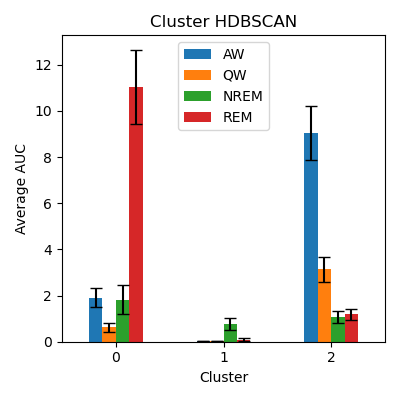

ClusterHDBSCAN
0    107
1     22
2     99
dtype: int64


In [11]:
data_origin['ClusterHDBSCAN'] = labels
grouped = data_origin.groupby('ClusterHDBSCAN')
means = grouped[data_origin.columns[:vigst_nb]].mean()
sems = grouped[data_origin.columns[:vigst_nb]].sem()

# Plot
ax = means.plot(kind='bar', yerr=sems, capsize=4, figsize=(4, 4))
plt.title('Cluster HDBSCAN')
plt.ylabel('Average AUC')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()
print(grouped.size())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


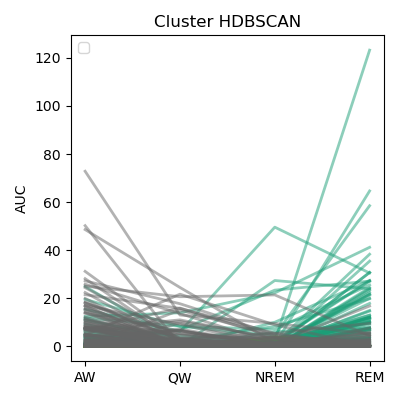

ClusterHDBSCAN
0    107
1     22
2     99
dtype: int64


In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

plt.figure(figsize=(4, 4))

# Generate a color for each group
groups = list(grouped.groups.keys())
colors = cm.get_cmap('Dark2', len(groups))

# Loop through each group
for idx, (name, group) in enumerate(grouped):
    color = colors(idx)  # assign a color based on group index
    for i in range(len(group)):
        plt.plot(group.columns[:-1], group.iloc[i][:-1], color=color, alpha=0.5, linewidth=2)

plt.title('Cluster HDBSCAN')
plt.ylabel('AUC')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

print(grouped.size())

Save clusters

In [1522]:
merged = pd.merge(combined_df, data_origin['ClusterHDBSCAN'], on='Unit_ID', how='outer') 
filenameOutAUC = f'{dpath}/VigStates_Global_cluster.xlsx'
merged.to_excel(filenameOutAUC)

filenameOut = f'{dpath}/VigStates_Global_cluster.pkl'
with open(filenameOut, 'wb') as pickle_file:
    pickle.dump(merged, pickle_file)